In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import ast
import numpy as np
import gensim.downloader as api # type: ignore
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats as stats
from sklearn.preprocessing import QuantileTransformer
import torch
import logging
import pickle
import os
from tqdm import tqdm
from transformers import pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

/Users/ohungchan/Documents/GitHub/bt4222grp9/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Datasets

In [88]:
playlist = pd.read_parquet("../phase2_data_cleaning/cleaned dataset/playlist_cleaned.parquet")
track = pd.read_parquet("../phase2_data_cleaning/cleaned dataset/track_cleaned.parquet")

# Categorization of Columns

### `release_year`

For tracks released earlier than 1960, we will classify it as 'Early Years'. <br> <br>
For tracks released between 1960 and 1980, we will classify it as 'Classic Era'. <br> <br>
For tracks released between 1980 and 2000, we will classify it as 'Golden Era'. <br> <br>
For tracks released between 2000 and 2010, we will classify it as '2010s'. <br> <br>
For tracks released after 2010, we will classify it as 'Modern Era'. <br> <br><br>
**We will now refer to these categories as `era`**

In [89]:
def categorize_era(year):
    if year < 1960:
        return "Early Years"
    elif 1960 <= year < 1980:
        return "Classic Era"
    elif 1980 <= year < 2000:
        return "Golden Era"
    elif 2000 <= year < 2010:
        return "2000s"
    else:
        return "Modern Era"

track["era"] = track["release_year"].apply(categorize_era)

Barplot of `era`

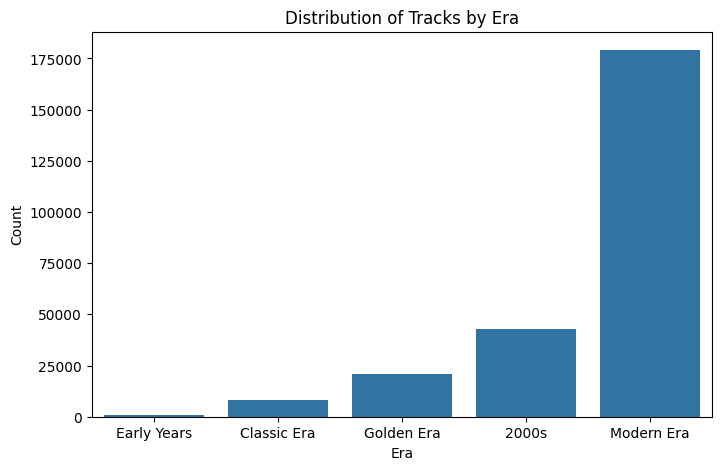

In [90]:
# Create the bar plot
plt.figure(figsize=(8, 5))
sns.countplot(x="era", data=track, order=["Early Years", "Classic Era", "Golden Era", "2000s", "Modern Era"])

# Customize the plot
plt.xlabel("Era")
plt.ylabel("Count")
plt.title("Distribution of Tracks by Era")

# Show the plot
plt.show()

Drop `release_year` since we have categorized it

In [91]:
track = track.drop(columns="release_year")

### `duration`

For tracks shorter than 180 seconds (3 min), we will classify it as short. <br> <br>
For tracks between 180 seconds (3 min) and 240 seconds (4 min), we will classify it as medium. <br> <br>
For tracks longer than 240 seconds (4 min), we will classify it as short. <br> <br> <br>
**We will now refer to these categories as `length`**

In [92]:
def categorize_duration(duration):
    if duration < 180:
        return "Short"
    elif 180 <= duration < 240:
        return "Medium"
    else:
        return "Long"

track['length'] = track['duration'].apply(categorize_duration)

Barplot of `length`

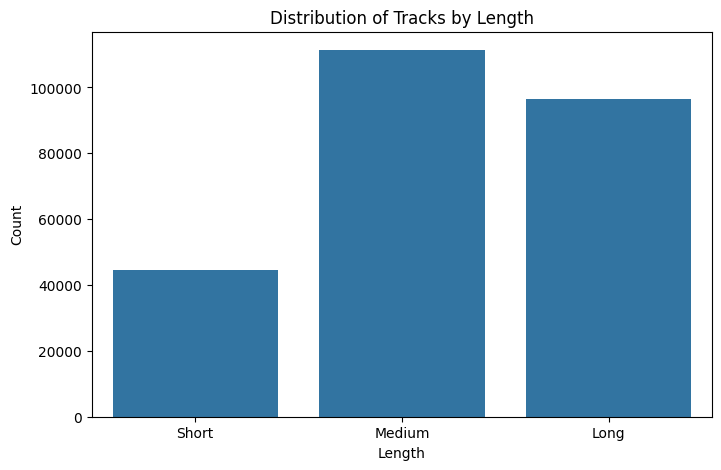

In [93]:
# Create the bar plot
plt.figure(figsize=(8, 5))
sns.countplot(x="length", data=track, order=["Short", "Medium", "Long"])

# Customize the plot
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Tracks by Length")

# Show the plot
plt.show()

Drop `duration` since we have categorized it

In [94]:
track = track.drop(columns="duration")

# One-Hot Encoding of the Categories

### One-hot encode the `era` column

In [95]:
track = pd.get_dummies(track, columns=["era"], prefix="", prefix_sep="")

### One-hot encode the `length` column

In [96]:
track = pd.get_dummies(track, columns=["length"], prefix="", prefix_sep="")
print(track.head())

   track_idx                             track_uri              album_name  \
0          0  spotify:track:000DfZJww8KiixTKuk9usJ  The Change I'm Seeking   
1          1  spotify:track:000GjfnQc7ggBayDiy1sLW         Y las Mariposas   
2          2  spotify:track:000JCyEkMFumqCZQJAORiQ        Enough Is Enough   
3          3  spotify:track:000VZqvXwT0YNqKk7iG2GS              Dear Youth   
4          4  spotify:track:000uWezkHfg6DbUPf2eDFO          Dancehall Days   

   album_idx            artist_name  artist_idx                track_name  \
0      78824              Mike Love       20091                Earthlings   
1      19030  El Poder De Zacatecas       26382               Abeja Miope   
2      80563          Nipsey Hussle        1633          California Water   
3     118169       The Ghost Inside       47069                     Mercy   
4      55985    The Beautiful Girls        4863  Me I Disconnect From You   

   danceability  energy  key  ...  \
0         0.631   0.513  2.0  .

# Stop Running

In [51]:
5 / 0

ZeroDivisionError: division by zero

# Audio Clustering Analysis

### 1. Summary: Selecting Audio Features for Clustering and Data Cleaning

- **Select Audio Features:**
  - A list named `audio_features` is defined with the column names representing various audio characteristics (e.g., "danceability", "energy").
  - These features are chosen for their ability to quantitatively distinguish between different aspects of the songs, making them suitable for clustering analysis.

- **Clean the Dataset:**
  - Rows containing missing values (`NaN`) in any of the specified audio feature columns are removed using `df.dropna(subset=audio_features)`.
  - The shape of the cleaned DataFrame is printed, which helps in assessing how many rows were removed and ensures that the dataset used for clustering is complete.


In [ ]:
# Ensure that your DataFrame 'df' is defined from previous analysis.
# Select audio features for clustering
audio_features = [
    "danceability", "energy", "key", "loudness",
    "speechiness", "acousticness", "instrumentalness",
    "liveness", "valence", "tempo"
]

# Clean data: drop rows with missing audio feature values
df = df.dropna(subset=audio_features)
print("Data shape after dropping missing values:", df.shape)

### 2. Normalizing Features and Finding the Optimal Number of Clusters

- **Normalize Features:**
  - Uses `QuantileTransfomer` to standardize & normalize selected audio features from the DataFrame.
  - Transforms the features so they have a mean of 0 and a standard deviation of 1.
  - The resulting standardized features are stored in a new DataFrame called `df_scaled`.

- **Determine Optimal Clusters (Elbow Method):**
  - Iterates over cluster counts from 2 to 10.
  - For each cluster count (k), it fits a K-Means model on `df_scaled` and records:
    - **Inertia:** Sum of squared distances from each point to its cluster center.
    - **Silhouette Score:** A measure of how distinct the clusters are.
    
- **Plot the Elbow Curve:**
  - Plots the inertia values against the number of clusters.
  - The "elbow" point in the plot helps visually determine the optimal number of clusters.



In [ ]:
# Normalize features
scaler = QuantileTransformer(output_distribution='normal')  # or 'uniform' depending on needs
df_scaled = pd.DataFrame(scaler.fit_transform(df[audio_features]), columns=audio_features)

# Find optimal number of clusters using the Elbow Method
inertia = []
sil_scores = []
K_range = range(2, 11)  # Testing cluster sizes from 2 to 10
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker="o", linestyle="-", label="Inertia")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.legend()
plt.show()

### 3. K-Means Clustering and Cluster Centroid Analysis

- **Setting Up Clustering:**
  - The optimal number of clusters is defined by setting `optimal_k = 8`. This value can be adjusted if needed.

- **Applying K-Means Clustering:**
  - A K-Means model is initialized with:
    - `n_clusters=optimal_k`: using 8 clusters.
    - `random_state=42`: ensuring reproducible results.
    - `n_init=10`: running the algorithm 10 times with different centroid seeds.
  - The model is fitted on the normalized features (`df_scaled`), and the predicted cluster labels are assigned to a new column `"cluster"` in the DataFrame `df`.

- **Analyzing Cluster Centroids:**
  - The centroids (i.e., the average feature values for each cluster) are extracted from the fitted K-Means model.
  - These centroids are organized into a new DataFrame `cluster_centers` with column names corresponding to the selected audio features.

- **Visualizing Cluster Centroids:**
  - A heatmap is generated using seaborn to display the centroids.
  - The heatmap provides a visual overview of the cluster characteristics, with the x-axis representing audio features and the y-axis representing cluster numbers.


In [ ]:
# Set the optimal number of clusters (update if needed)
optimal_k = 8

# K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(df_scaled)

# Analyze cluster centroids
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=audio_features)

# Heatmap of cluster centroids
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_centers, cmap="Purples", annot=True)
plt.title("Cluster Centroids (K-means)")
plt.xlabel("Audio Features")
plt.ylabel("Cluster Number")
plt.show()

### 4. PCA for 3D Visualization of Clusters

- **Applying PCA with 3 Components:**
  - A PCA model is initialized with 3 components using `PCA(n_components=3)`.
  - The normalized features (`df_scaled`) are transformed into a 3-dimensional space, resulting in an array `df_pca`.
  - The three principal components are then stored in the DataFrame `df` as new columns: `PCA1`, `PCA2`, and `PCA3`.

- **3D Visualization of Clusters:**
  - A 3D plot is created using matplotlib:
    - A new figure is set up with a size of 10x8 inches.
    - A 3D subplot is added to the figure using `projection="3d"`.
  - A scatter plot is generated:
    - The x, y, and z coordinates are given by `PCA1`, `PCA2`, and `PCA3`, respectively.
    - Points are colored based on the cluster labels stored in `df["cluster"]` with the `tab10` colormap.
    - A marker size of 50 is used for better visibility.
  - The axes are labeled with the corresponding PCA component names, and a title is added to the plot.
  - A legend is created from the scatter plot elements to indicate which colors correspond to which clusters.
  - Finally, the plot is displayed using `plt.show()`.


In [ ]:
# Use PCA with 3 components for 3D visualization
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_scaled)
df["PCA1"] = df_pca[:, 0]
df["PCA2"] = df_pca[:, 1]
df["PCA3"] = df_pca[:, 2]

# 3D Visualization of Clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(df["PCA1"], df["PCA2"], df["PCA3"], c=df["cluster"], cmap="tab10", s=50)
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("3D Clustering Visualization using PCA")
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)
plt.show()

### 5. Assigning Genre Scores (Soft Clustering) and Cluster Labels

- **Computing Distances and Converting to Similarity Scores:**
  - **Step 1:**  
    ```python
    distances = cdist(df_scaled, kmeans.cluster_centers_, metric="euclidean")
    ```
    - Computes the Euclidean distance between each song (from the normalized feature set `df_scaled`) and each cluster centroid from the K-Means model.
  - **Step 2:**  
    ```python
    genre_scores = np.exp(-distances)  # Convert distances to similarity scores
    ```
    - Applies an exponential decay function (`np.exp(-distance)`) to convert distances into similarity scores.
    - Songs that are closer to a centroid (i.e., with smaller distances) yield higher similarity values.
    
- **Normalizing Genre Scores:**
  - **Step 3:**  
    ```python
    genre_scores = genre_scores / genre_scores.sum(axis=1, keepdims=True)  # Normalize scores
    ```
    - Normalizes the similarity scores for each song so that the scores across all clusters sum to 1.
    - **Interpretation Example:**  
      - Suppose a song has raw similarity scores `[2.5, 0.5, 0.3, 0.1, 0.05, 0.05, 0.03, 0.02]`.  
      - After normalization, these might become approximately `[0.80, 0.10, 0.06, 0.02, 0.01, 0.01, 0.005, 0.005]`.  
      - This means the song is most similar to the first cluster (80% similarity), with much lower similarities to the other clusters, indicating its ***strongest genre affiliation***.

- **Storing Genre Scores:**
  - **Step 4:**  
    ```python
    genre_scores_df = pd.DataFrame(genre_scores, columns=[f"Genre {i}" for i in range(optimal_k)])
    df = pd.concat([df, genre_scores_df], axis=1)
    ```
    - Creates a new DataFrame `genre_scores_df` with columns named "Genre 0" through "Genre 7" (for `optimal_k = 8`).

- **Assigning Descriptive Cluster Labels:**
  - **Step 5:**  
    ```python
    descriptive_labels = [
        "Instrumental / Ambient Sounds",    # Cluster 0
        "Soft Acoustic / Classical",          # Cluster 1
        "Orchestral / Soundtrack",            # Cluster 2
        "Mid-tempo Pop / Indie",              # Cluster 3
        "Upbeat Electronic / Dance",          # Cluster 4
        "Slow & Melancholic (Sad Songs)",     # Cluster 5
        "Experimental / Jazz Fusion",         # Cluster 6
        "Lo-Fi / Chill Vibes"                 # Cluster 7
    ]
    df["Cluster Label"] = df["cluster"].map(lambda x: descriptive_labels[x])
    df.to_csv("1000_songs_processed_music_dataset.csv", index=False)
    ```
    - Maps numeric cluster labels from the K-Means output to descriptive text labels.
    - The resulting labels help in quickly understanding the genre or style associated with each cluster.

- **Final Output:**
  - The script prints the first few rows of the updated DataFrame, displaying the original song data, cluster assignments, soft genre scores, and descriptive cluster labels.


In [ ]:
# Assign Genre Scores (Soft clustering)
distances = cdist(df_scaled, kmeans.cluster_centers_, metric="euclidean")
genre_scores = np.exp(-distances)  # Convert distances to similarity scores
genre_scores = genre_scores / genre_scores.sum(axis=1, keepdims=True)  # Normalize scores

# Store genre scores in a new DataFrame
genre_scores_df = pd.DataFrame(genre_scores, columns=[f"Genre {i}" for i in range(optimal_k)])
df = pd.concat([df, genre_scores_df], axis=1)

# Assign descriptive labels to each cluster (adjust labels as needed)
descriptive_labels = [
    "Instrumental / Ambient Sounds",      # Cluster 0
    "Soft Acoustic / Classical",          # Cluster 1
    "Orchestral / Soundtrack",            # Cluster 2
    "Mid-tempo Pop / Indie",              # Cluster 3
    "Upbeat Electronic / Dance",          # Cluster 4
    "Slow & Melancholic (Sad Songs)",     # Cluster 5
    "Experimental / Jazz Fusion",         # Cluster 6
    "Lo-Fi / Chill Vibes"                 # Cluster 7
]

df["Cluster Label"] = df["cluster"].map(lambda x: descriptive_labels[x])
df.to_csv("1000_songs_processed_music_dataset.csv", index=False)

print("Audio clustering with 3D PCA visualization completed. Here are the first few rows:")
print(df.head())

### 6. Displaying the Count of Songs per Cluster

- **Purpose:**
  - This section displays how many songs are assigned to each cluster based on the descriptive labels.

- **Details:**
  - `df["Cluster Label"].value_counts()` is used to count and display the number of songs in each cluster.
    - `value_counts()` returns a series where the index contains the unique cluster labels and the corresponding values indicate how many times each label appears in the DataFrame.
  - **Interpretation:**
    - The output provides a quick summary of the distribution of songs among the different clusters, helping to assess cluster sizes and the overall balance of the clustering result.


In [ ]:
print("\nSongs per Cluster:")
print(df["Cluster Label"].value_counts())

### 7. Merge dataframes

NOT NEEDED IN FINAL VERSION

In [97]:
genre_scores = pd.read_parquet("scores/genre_scores.parquet")

ACTUAL ONE (Store track_idx instead of track_uri)

In [98]:
track = pd.merge(track, genre_scores, on="track_uri", how="inner") 
audio_features = [
    "danceability", "energy", "key", "loudness",
    "speechiness", "acousticness", "instrumentalness",
    "liveness", "valence", "tempo", "time_signature", "mode"
]
track = track.drop(columns=audio_features)

NOT NEEDED IN FINAL VERSION (IMPUTE MISSING VALUES)

In [99]:
# Define the DataFrame (assuming track_audio is already loaded)
columns_to_impute = [
    "Instrumental / Ambient Sounds", "Soft Acoustic / Classical", "Orchestral / Soundtrack",
    "Mid-tempo Pop / Indie", "Upbeat Electronic / Dance", "Slow & Melancholic (Sad Songs)",
    "Experimental / Jazz Fusion", "Lo-Fi / Chill Vibes"
]

# Impute missing values with the median for each column
track.loc[:, columns_to_impute] = track[columns_to_impute].fillna(track[columns_to_impute].median())

# Normalize so that each row sums to 1
row_sums = track[columns_to_impute].sum(axis=1)

# Avoid division by zero, normalize, then replace NaNs with 0 (if a row was entirely 0)
track.loc[:, columns_to_impute] = track[columns_to_impute].div(row_sums, axis=0).fillna(0)

# Lyrics Sentiment Analysis

### 1. Setup Logging
- Enables tracking of script execution and debugging.
- Configured to display timestamps, log levels, and messages.
- Uses INFO level to show key updates.

In [ ]:
logging.basicConfig(format="%(asctime)s - %(levelname)s - %(message)s", level=logging.INFO)

2025-03-20 13:31:53,970 - INFO - 🔹 Loading dataset...
2025-03-20 13:31:54,542 - INFO - ✅ Using 175878 valid lyrics for Zero-Shot Classification.


### 2. Load Dataset & Preprocess Lyrics
- Applies preprocessing to clean the lyrics column before running the classification.
- Drop rows where lyrics is NaN.
- Remove rows where lyrics contain placeholder values (\"No Lyrics\", \"none\", \"None\") to ensure high-quality data.
- Convert the cleaned lyrics and track IDs into lists, which makes them easier to process in subsequent classification steps

In [ ]:
logging.info("🔹 Loading dataset...")
df = pd.read_parquet("/Users/xavierhua/Documents/GitHub/bt4222grp9/phase2_data_cleaning/cleaned dataset/track_cleaned.parquet")

# Validate if 'lyrics' column exists
if "lyrics" not in df.columns:
    raise ValueError("❌ The dataset must contain a 'lyrics' column.")

# Drop missing or invalid lyrics
df = df.dropna(subset=["lyrics"])
df = df[~df["lyrics"].isin(["No Lyrics", "none", "None"])].copy()

# Convert lyrics and track IDs to lists
lyrics_list = df["lyrics"].tolist()
track_idx_list = df["track_idx"].tolist()
logging.info(f"✅ Using {len(df)} valid lyrics for Zero-Shot Classification.")

### 3. Load Zero-Shot Classification Model
- Initializes a pre-trained zero-shot classification model to classify lyrics into predefined emotion categories.
- Why Zero-Shot Classification? Zero-shot classification allows categorization without task-specific training, making it flexible for emotion detection.
- The model will classify lyrics into the specified emotion categories based on context and meaning.

In [ ]:
logging.info("🔹 Loading Zero-Shot Classifier...")
device = 0 if torch.cuda.is_available() else -1
model_name = "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"
classifier = pipeline(
    "zero-shot-classification",
    model=model_name,
    device=device,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
)

# Define emotion categories
emotions = ["joy", "calm", "sadness", "fear", "energizing", "dreamy"]

### 4. Checkpoint Setup
- To avoid reprocessing from the beginning in case of interruptions, a checkpoint system is used to save progress and resume efficiently.
- `checkpoint_path`: File to store progress.
- `start_idx`: Tracks the last processed index.
- `emotion_scores`: Stores emotion classification results.
- `track_ids`: Stores processed track IDs.
- If a checkpoint exists, it loads the last processed index and saved results to continue from where it left off.

In [ ]:
checkpoint_path = "classification_checkpoint.pkl"
start_idx = 0
emotion_scores = {emotion: [] for emotion in emotions}
track_ids = []

# Resume from checkpoint if exists
if os.path.exists(checkpoint_path):
    logging.info("🔄 Resuming from last checkpoint...")
    with open(checkpoint_path, "rb") as f:
        saved_data = pickle.load(f)
        start_idx = saved_data["last_processed_idx"]
        emotion_scores = saved_data["emotion_scores"]
        track_ids = saved_data["track_ids"]

logging.info(f"🔹 Resuming from index {start_idx} / {len(lyrics_list)}")

### 5. Batched Zero-Shot Classification
- Processes lyrics in batches using a zero-shot classification model to determine emotion scores efficiently.
- Uses a defined batch size to optimize performance and prevent memory overload.
- Stores results and periodically saves checkpoints to resume from the last processed index in case of interruptions.

In [ ]:
batch_size_classify = 32  # Increase batch size if possible
logging.info("🔹 Running Zero-Shot Classification...")

batches_processed = 0
for i in tqdm(range(start_idx, len(lyrics_list), batch_size_classify), desc="Classifying Emotions"):
    # Get batch data
    batch_lyrics = lyrics_list[i:i + batch_size_classify]
    batch_track_ids = track_idx_list[i:i + batch_size_classify]
    
    # Run classification
    batch_results = classifier(batch_lyrics, candidate_labels=emotions, multi_label=True)
    if isinstance(batch_results, dict):
        batch_results = [batch_results]

    # Store results
    for idx, result in enumerate(batch_results):
        track_ids.append(batch_track_ids[idx])
        scores_dict = dict(zip(result["labels"], result["scores"]))
        for emotion in emotions:
            emotion_scores[emotion].append(scores_dict.get(emotion, 0.0))
    
    # Save checkpoint periodically
    batches_processed += 1
    if batches_processed % 2 == 0:  # Adjust frequency as needed
        with open(checkpoint_path, "wb") as f:
            pickle.dump({
                "last_processed_idx": i + batch_size_classify,
                "emotion_scores": emotion_scores,
                "track_ids": track_ids
            }, f)
        logging.info(f"💾 Checkpoint saved at index {i + batch_size_classify}")

logging.info("✅ Classification complete. Saving results...")

### 6. Save Results
- Ensures all lists have the same length to prevent data mismatches.
- Trims `track_ids` and `emotion_scores` to the minimum length.
- Creates a DataFrame with track IDs and emotion scores.
- Removes duplicate entries to maintain unique track records.
- Saves the processed data as `full_dataset_emotion_scores.csv`.
- Deletes the checkpoint file after successful completion.
- Logs completion and confirms that results have been saved.

In [ ]:
# Ensure all lists have the same length
min_length = min(len(track_ids), *[len(scores) for scores in emotion_scores.values()])
track_ids = track_ids[:min_length]
emotion_scores = {k: v[:min_length] for k, v in emotion_scores.items()}

# Create and save DataFrame
output_df = pd.DataFrame({
    "track_idx": track_ids,
    **emotion_scores
})
output_df = output_df.drop_duplicates(subset=["track_idx"], keep="first")
output_df.to_csv("full_dataset_emotion_scores.csv", index=False)

# Remove checkpoint file
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)

logging.info("✅ Full dataset emotion scores saved as 'full_dataset_emotion_scores.csv'.")
print("✅ Emotion classification complete! Results saved.")

### 7. Row-wise Sum Normalization on Emotions
- Computes the sum of emotion scores for each track (row-wise).
- Normalizes each row by dividing emotion scores by the row sum.
- Handles cases where the sum is zero to avoid NaN values.
- Saves the normalized dataset as `normalized_emotion_scores.csv`.

In [ ]:
# Load dataset(Optional)
output_df = pd.read_csv("/Users/xavierhua/Documents/GitHub/bt4222grp9/phase3_feature_engineering/sentiment analysis/full_dataset_emotion_scores.csv")

# Define emotion columns
emotion_columns = ["joy", "calm", "sadness", "fear", "energizing", "dreamy"]

# Compute row-wise sum
row_sums = output_df[emotion_columns].sum(axis=1)

# Normalize each row by dividing by the row sum
output_df[emotion_columns] = output_df[emotion_columns].div(row_sums, axis=0).fillna(0)

# Save the normalized results
output_df.to_csv("normalized_emotion_scores.csv", index=False)

# Handle Missing Values

There are 76,356 rows with missing sentiment scores

Load Dataset (NOT NEEDED IN FINAL VERSION) <br><br>
We need an output from lyrics analysis with only columns: track_idx, 6 emotions

In [100]:
track_sentiment = pd.read_parquet("scores/sentiment_scores_1000_subsample.parquet")
tracks = pd.read_parquet("../1000_sampling/datasets/1000_track_idx_only.parquet")
#filtered_tracks = track[track["track_idx"].isin(tracks["track_idx"])]
track = pd.merge(track, track_sentiment, on="track_idx", how='left')

Actual Version (Uncomment later)

In [ ]:
# track = pd.merge(track, output_df, on="track_idx", how='left')
# track = track.drop(columns="lyrics")
sentiment_columns = ["joy", "calm", "sadness", "fear", "energizing", "dreamy"]

Firstly, impute by using the mean sentiment of the same album

In [102]:
before_imputation_album = track[sentiment_columns].isna().sum().sum()
track.loc[:, sentiment_columns] = track.groupby("album_idx")[sentiment_columns].transform(lambda x: x.fillna(x.mean()))
after_imputation_album = track[sentiment_columns].isna().sum().sum()
imputed_album = before_imputation_album - after_imputation_album
print(f"Imputed {int(imputed_album / 6)} rows using the album mean.")

Imputed 42236 rows using the album mean.


Next, impute by using the mean of the same artist

In [103]:
before_imputation_artist = track[sentiment_columns].isna().sum().sum()
track.loc[:, sentiment_columns] = track.groupby("artist_idx")[sentiment_columns].transform(lambda x: x.fillna(x.mean()))
after_imputation_artist = track[sentiment_columns].isna().sum().sum()
imputed_artist = before_imputation_artist - after_imputation_artist
print(f"Imputed {int(imputed_artist / 6)} rows using the artist mean.")

Imputed 62796 rows using the artist mean.


Finally, impute by using the global mean

In [104]:
before_imputation_global = track[sentiment_columns].isna().sum().sum()
track.loc[:, sentiment_columns] = track[sentiment_columns].fillna(track[sentiment_columns].mean())
after_imputation_global = track[sentiment_columns].isna().sum().sum()
imputed_global = before_imputation_global - after_imputation_global
print(f"Imputed {int(imputed_global / 6)} rows using the global mean.")

remaining_missing = track[sentiment_columns].isna().sum().sum()
print(f"Remaining missing rows: {remaining_missing}")

Imputed 115917 rows using the global mean.
Remaining missing rows: 0


Since each rows has been imputed by different means, the rows are not normalized yet. 

We normalize the rows that has been imputed

In [105]:
track.loc[:, sentiment_columns] = track[sentiment_columns].div(track[sentiment_columns].sum(axis=1), axis=0)

### Missing Values Status

In [106]:
print(track.isnull().sum())  

track_idx                             0
track_uri                             0
album_name                            0
album_idx                             0
artist_name                           0
artist_idx                            0
track_name                            0
lyrics                            76349
track_popularity                      0
2000s                                 0
Classic Era                           0
Early Years                           0
Golden Era                            0
Modern Era                            0
Long                                  0
Medium                                0
Short                                 0
Instrumental / Ambient Sounds         0
Soft Acoustic / Classical             0
Orchestral / Soundtrack               0
Mid-tempo Pop / Indie                 0
Upbeat Electronic / Dance             0
Slow & Melancholic (Sad Songs)        0
Experimental / Jazz Fusion            0
Lo-Fi / Chill Vibes                   0


All missing values have now been handled

# Save Dataset

In [107]:
track = track.drop(columns=["track_uri", "album_name", "artist_name", "track_name", "lyrics"])
track.to_parquet("feature engineered datasets/tracks_temp.parquet", index=False)